- 收集数据：提供的文本文件
- 准备数据：解析tab键分割的数据
- 分析数据：快速检查数据
- 训练算法：
- 测试算法：编写测试函数 验证决策树可以正确分类给定的数据实例
- 使用算法：存储树的数据结构，以便下次使用

In [1]:
from math import log
import operator

In [2]:
def calcShannonEnt(dataSet):
    numEntries = len(dataSet)
    # 为所有可能分类创建字典
    labelCounts= {}
    for featVec in dataSet:
        currentLabel = featVec[-1]
        if currentLabel not in labelCounts.keys():
            labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1
    shannonEnt = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key])/numEntries
        shannonEnt -= prob * log(prob,2)   # 以 2为底求对数
    return shannonEnt     

In [3]:
# 按照给定特征划分数据集
# 输入参数： 待划分待数据集、划分数据集的特征、需要返回的特征的值
def splitDataSet(dataSet,axis,value):
    retDataSet = []
    for featVec in dataSet:
        print("featVec",featVec)
        if featVec[axis] == value:
            print("axis",axis,"featVec[axis]",featVec[axis])
            reducedFeatVec = featVec[:axis]
            print("axis",axis,"reducedFeatVec:",reducedFeatVec)
            reducedFeatVec.extend(featVec[axis+1:])
            print("featVec[axis+1:]",featVec[axis+1:])
            print("axis",axis,"reducedFeatVec:",reducedFeatVec)
            retDataSet.append(reducedFeatVec)
    return retDataSet

In [4]:
# 选择最好的数据集划分方式
def chooseBestFeatureToSplit(dataSet):
    numFeatures = len(dataSet[0])-1  #特征的个数
    baseEntropy = calcShannonEnt(dataSet) # 基线熵
    print("baseEntropy:",baseEntropy)
    bestInfoGain = 0.0
    bestFeature = -1
    # 创建唯一的分类标签
    for i in range(numFeatures):
        featList = [example[i] for example in dataSet]
        print("featList:",featList)
        uniqueVals =  set(featList)
        print("uniqueVals:",uniqueVals)
        
        # 计算每种划分方式的信息熵
        newEntropy = 0.0
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet, i ,value)
            prob = len(subDataSet) / float(len(dataSet))
            newEntropy += prob * calcShannonEnt(subDataSet)
        infoGain = baseEntropy - newEntropy  # 计算信息增益
        print("baseEntropy",baseEntropy,"i:",i,"newEntropy",newEntropy,"infoGain",infoGain)
        if(infoGain > bestInfoGain):
            bestInfoGain = infoGain   # 计算最好的信息增益
            bestFeature = i
    return bestFeature

In [5]:
def majorityCnt(classList):
    classCount = {}
    for vote in classCount:
        if vote not in classCount.keys():
            classCount[vote] =0
        classCount[vote] += 1
    sortedClassCount = sorted(classCount.items(), key=operator.itemgetter(1), reverse =True)
    return sortedClassCount[0][0]

In [6]:
# 创建决策树
def createTree(dataSet,labels):
    classList = [example[-1] for example in dataSet]
    print("labels:",labels)
    print("classList:",classList)
    print("classList[0]:",classList[0])
    print("classList.count(classList[0]):",classList.count(classList[0]))
    
    ## 类别相同则停止划分
    if classList.count(classList[0]) == len(classList):
        return classList[0]
    
    ## 遍历完所有特征时 返回出现次数最多的
    if len(dataSet[0]) == 1:
        return majorityCnt(classList)
    
    bestFeat = chooseBestFeatureToSplit(dataSet)
    bestFeatLabel = labels[bestFeat] 
    print("bestFeatLabel",bestFeatLabel)
    myTree = {bestFeatLabel:{}}
    print("myTree:::",myTree)
    del(labels[bestFeat])
    print("labels:",labels)
    featValues = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValues)
    for value in uniqueVals:
        subLabels = labels[:]
        print("subLabels:",subLabels)
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value),subLabels)
    return myTree

In [7]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
simheifont = FontProperties(fname='../simhei.ttf')

In [14]:
decisionNode = dict(boxstyle="sawtooth", fc="0.8")
leafNode = dict(boxstyle="round4", fc="0.8")
arrow_args = dict(arrowstyle="<-")
def plotNode(nodeTxt,centerPt,parentPt,nodeType):
    createPlot.ax1.annotate(nodeTxt,xy=parentPt, xycoords='axes fraction', 
                            xytext=centerPt, textcoords ='axes fraction',
                            va="center",ha="center",bbox=nodeType, arrowprops=arrow_args,
                            fontproperties= simheifont)

In [8]:
# 获取叶节点和树的层数
def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':   ## 测试节点的数据类型是否字典
            numLeafs += getNumLeafs(secondDict[key])
        else:
            numLeafs += 1
    return numLeafs

def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':   ## 测试节点的数据类型是否字典
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:
            thisDepth = 1
        if thisDepth > maxDepth:
            maxDepth = thisDepth
    return maxDepth

In [9]:
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0] - cntrPt[0]) /2.0 + cntrPt[0]
    yMid = (parentPt[1] - cntrPt[1]) /2.0 + cntrPt[1]
    createPlot.ax1.text(xMid,yMid, txtString)

def plotTree(myTree, parentPt, nodeText):
    numLeafs = getNumLeafs(myTree)
    depth = getTreeDepth(myTree)
    
    firstStr = list(myTree.keys())[0]
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs)) /2.0 / plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeText)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0 / plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            plotTree(secondDict[key], cntrPt, str(key))
        else:
            plotTree.xOff = plotTree.xOff + 1.0 / plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt,str(key))
    plotTree.yOff = plotTree.yOff + 1.0 / plotTree.totalD

def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = - 0.5/ plotTree.totalW
    plotTree.yOff = 1.0
    plotTree(inTree,(0.5,1.0),'')
    plt.show()

In [10]:
# 使用决策树的分类函数
def classify(inputTree,featLabels, testVec):
    firstStr = list(inputTree.keys())[0]
    secondDict = inputTree[firstStr]
    featIndex = featLabels.index(firstStr)
    print(featIndex)
    
    for key in secondDict.keys():
        if testVec[featIndex] == key:
            if type(secondDict[key]).__name__ == 'dict':
                classLabel = classify(secondDict[key], featLabels, testVec)
            else:
                classLabel = secondDict[key]
    return classLabel

In [11]:
def storeTree(inputTree,fileName):
    import _pickle as cPickle
    fw = open(fileName, 'w')
    cPickle.dump(inputTree,fw)
    fw.close()
    
def grabTree(fileName):
    import _pickle as cPickle
    fr = open(fileName)
    return cPickle.load(fr)

In [12]:
with open("./dataset/lenses.txt",'r') as fr:
    lenses = [inst.strip().split('\t')  for inst in fr.readlines()]
    print(lenses)
    lensesLabels = ['age','prescript','astigmatic','tearRate']
    lensesTree = createTree(lenses,lensesLabels)
    lensesTree

[['young', 'myope', 'no', 'reduced', 'no lenses'], ['young', 'myope', 'no', 'normal', 'soft'], ['young', 'myope', 'yes', 'reduced', 'no lenses'], ['young', 'myope', 'yes', 'normal', 'hard'], ['young', 'hyper', 'no', 'reduced', 'no lenses'], ['young', 'hyper', 'no', 'normal', 'soft'], ['young', 'hyper', 'yes', 'reduced', 'no lenses'], ['young', 'hyper', 'yes', 'normal', 'hard'], ['pre', 'myope', 'no', 'reduced', 'no lenses'], ['pre', 'myope', 'no', 'normal', 'soft'], ['pre', 'myope', 'yes', 'reduced', 'no lenses'], ['pre', 'myope', 'yes', 'normal', 'hard'], ['pre', 'hyper', 'no', 'reduced', 'no lenses'], ['pre', 'hyper', 'no', 'normal', 'soft'], ['pre', 'hyper', 'yes', 'reduced', 'no lenses'], ['pre', 'hyper', 'yes', 'normal', 'no lenses'], ['presbyopic', 'myope', 'no', 'reduced', 'no lenses'], ['presbyopic', 'myope', 'no', 'normal', 'no lenses'], ['presbyopic', 'myope', 'yes', 'reduced', 'no lenses'], ['presbyopic', 'myope', 'yes', 'normal', 'hard'], ['presbyopic', 'hyper', 'no', 'redu

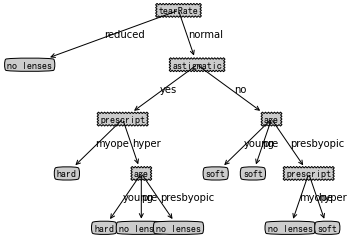

In [15]:
createPlot(lensesTree)